In [85]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

In [86]:
def moving_avg(x, N=1000):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

Initializing variables and reading datasets

In [87]:
dsets = []
accelpedal = []
driverdem = []
engtorque = []
path = r'Final_engine_sys_data'

In [88]:
og = pd.read_csv('engine_system.csv')
q0 = og['61443-91'].quantile(q=0.90)
q1 = og['61444-512'].quantile(q=0.95)
q2 = og['61444-513'].quantile(q=0.95)
print('80th Percentile: ' + str(q0))

80th Percentile: 73.60000000000001


In [89]:
for i in range(32):
    dsets.append(pd.read_csv(path + '\\final_engine_dset_' + str(i)+'.csv'))            #Moving averages are taken to smoothen the data
    ped = dsets[i]['61443-91'][dsets[i]['61443-91'] > q0]
    dem = dsets[i]['61444-512'][dsets[i]['61444-512'] > q1]
    tor = dsets[i]['61444-513'][dsets[i]['61444-513'] > q2]
    ped.dropna(inplace=True)
    dem.dropna(inplace=True)
    tor.dropna(inplace=True)
    vals = moving_avg(ped, 1000)
    accelpedal.append(vals[::100])
    vals = moving_avg(dem, 1000)
    driverdem.append(vals[::100])
    vals = moving_avg(tor, 1000)
    engtorque.append(vals[::100])

for i in range(6):
    dsets.append(pd.read_csv(path + '\\faulty_engine_dset_' + str(i)+'.csv'))
    ped = dsets[32+i]['61443-91'][dsets[32+i]['61443-91'] > q0]
    dem = dsets[32+i]['61444-512'][dsets[32+i]['61444-512'] > q1]
    tor = dsets[32+i]['61444-513'][dsets[32+i]['61444-513'] > q2]
    ped.dropna(inplace=True)
    dem.dropna(inplace=True)
    tor.dropna(inplace=True)
    vals = moving_avg(ped, 1000)                           #fix this
    accelpedal.append(vals[::100])
    vals = moving_avg(dem, 1000)
    driverdem.append(vals[::100])
    vals = moving_avg(tor, 1000)
    engtorque.append(vals[::100])

Reshape and format the datasets to be timeseries

In [90]:
formatted_pedal = to_time_series_dataset(accelpedal)
formatted_demand = to_time_series_dataset(driverdem)
formatted_torque = to_time_series_dataset(engtorque)
print("Accelerator Pedal Position Shape: " + str(formatted_pedal.shape))
print("Driver\'s Demand Torque Shape: " + str(formatted_demand.shape))
print("Actual Engine Torque Shape: " + str(formatted_torque.shape))

Accelerator Pedal Position Shape: (38, 102, 1)
Driver's Demand Torque Shape: (38, 84, 1)
Actual Engine Torque Shape: (38, 76, 1)


Plotting the timeseries

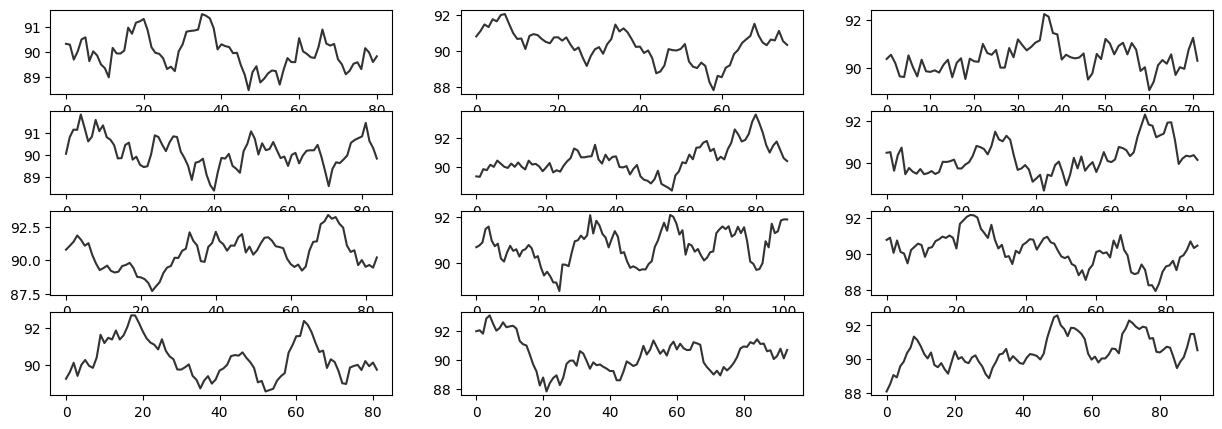

In [91]:
#Normal Accel Pedal
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_pedal[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

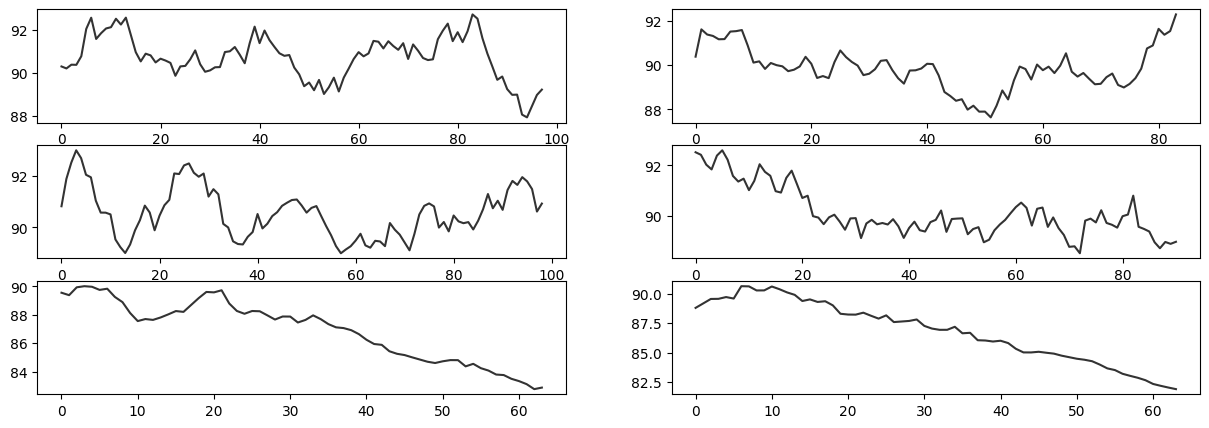

In [92]:
#Some Accel Pedal with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_pedal[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

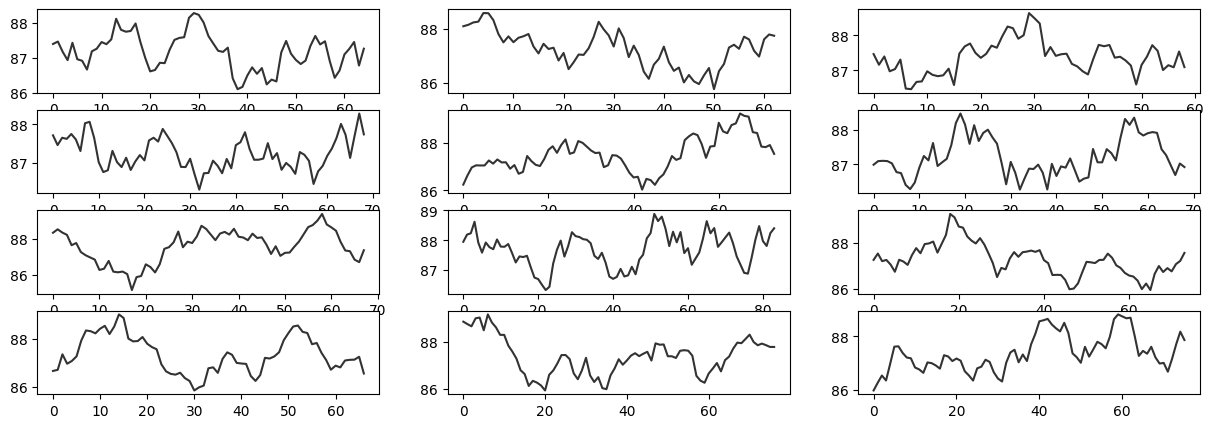

In [93]:
#Normal Driver's Demand
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_demand[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

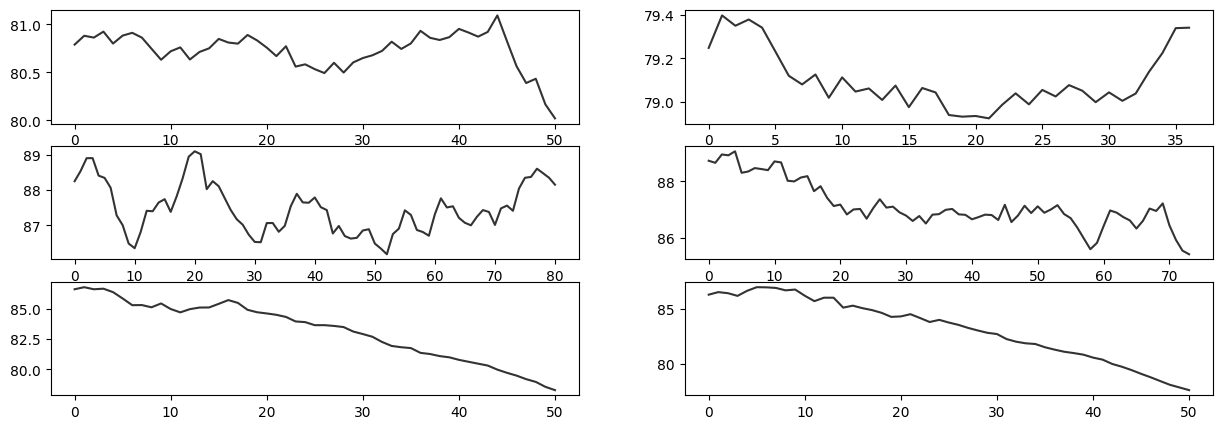

In [94]:
#Some Driver's Demand with Faults
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_demand[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

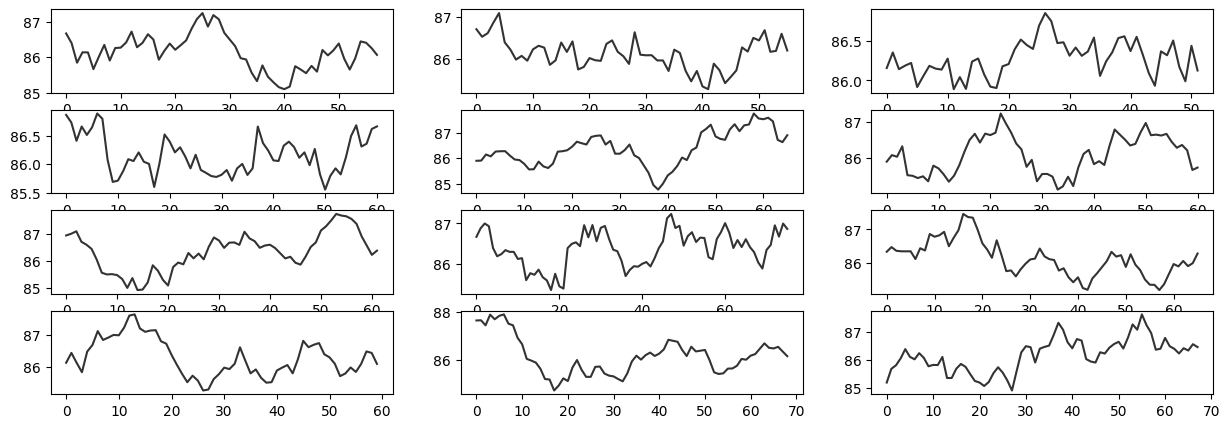

In [95]:
#Normal Actual Engine Torque
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_torque[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

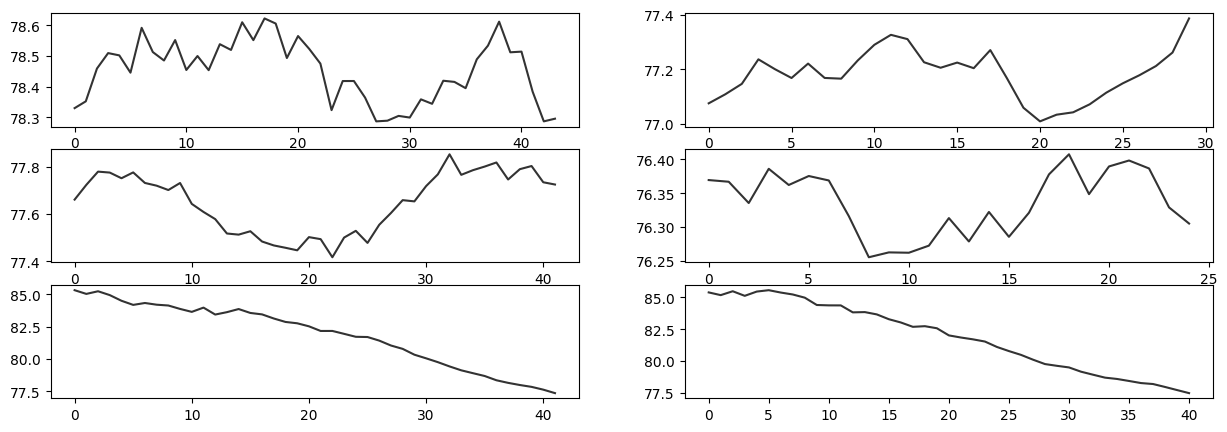

In [96]:
#Some Actual Engine with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_torque[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

Checking Number of Clusters needed using the Elbow method and silhouette score

In [97]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=10,
                          max_iter_barycenter=1000,                          
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_torque)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_torque)
    sil_score = silhouette_score(formatted_torque, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.8740124907717981
[23.274544714813732]
0.8751991797654834
[23.274544714813732, 9.016132281838155]
0.8262931797227808
[23.274544714813732, 9.016132281838155, 5.908796132165247]
0.16218241096634634
[23.274544714813732, 9.016132281838155, 5.908796132165247, 5.271742877973764]
0.18968959794788304
[23.274544714813732, 9.016132281838155, 5.908796132165247, 5.271742877973764, 4.215197922358394]


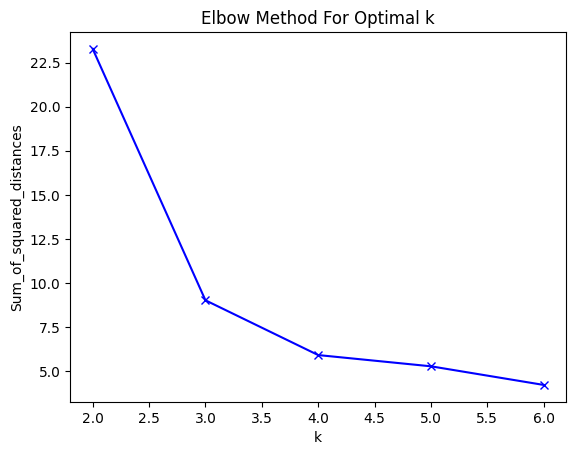

In [98]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for engine torque using DTW

DBA k-means
DBA silhoutte: 0.88
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[32 33 34 35]
[36 37]


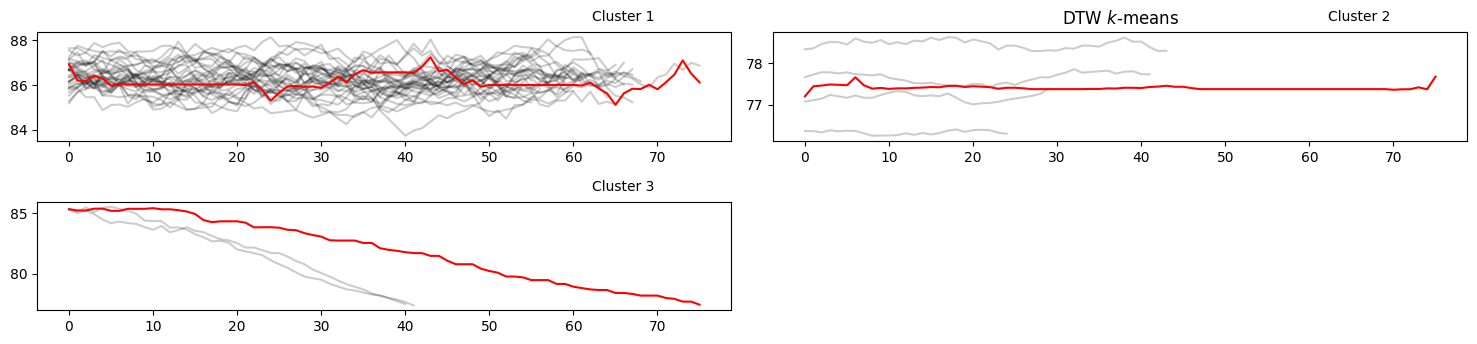

In [99]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=10,
                          max_iter_barycenter=1000,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_torque)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_torque, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_torque[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

    
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])

plt.tight_layout()
plt.show()

Checking clusters for Driver's Demand

In [100]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=10,
                          max_iter_barycenter=1000,                          
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_demand)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_demand)
    sil_score = silhouette_score(formatted_demand, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.85633948221651
[13.982055158963249]
0.8418348637084714
[13.982055158963249, 9.944019983242276]
0.24253675081189824
[13.982055158963249, 9.944019983242276, 8.366805951888642]
0.17518298381345712
[13.982055158963249, 9.944019983242276, 8.366805951888642, 7.142510141850568]
0.17174962258774412
[13.982055158963249, 9.944019983242276, 8.366805951888642, 7.142510141850568, 6.514997955542633]


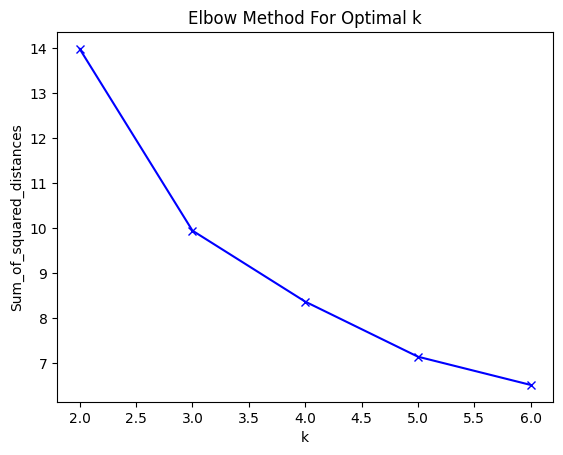

In [101]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for Driver's Demand using DTW

DBA k-means
DBA silhoutte: 0.84
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 34 35]
[36 37]
[32 33]


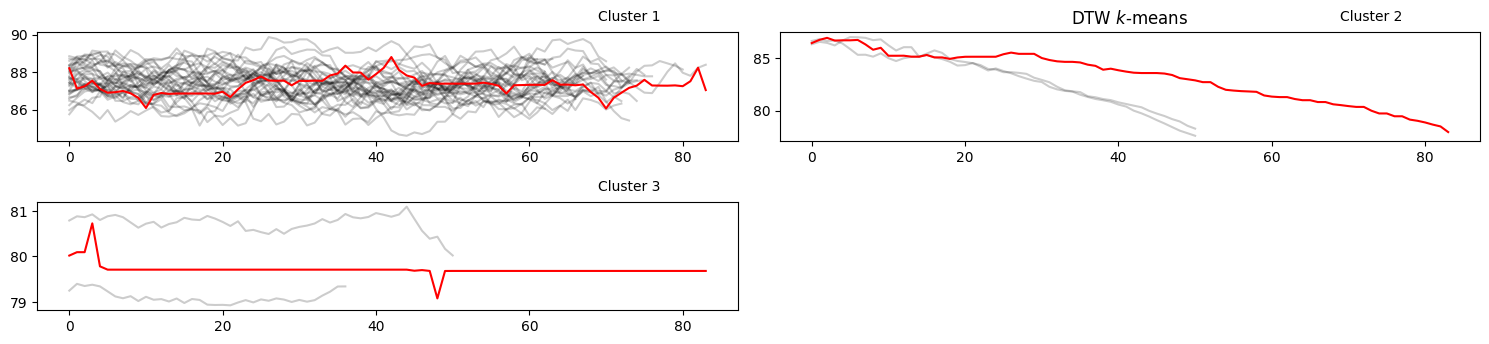

In [102]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=5,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_demand)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_demand, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_demand[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])

plt.tight_layout()
plt.show()

Checking clusters for Accelerator Pedal Position

In [103]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=10,
                          max_iter_barycenter=1000,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_pedal)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_pedal)
    sil_score = silhouette_score(formatted_pedal, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.7883765022719037
[16.941166006412107]
0.1808399278525286
[16.941166006412107, 14.393522078842242]
0.17064352154587956
[16.941166006412107, 14.393522078842242, 12.586078816833897]
0.1545948838356254
[16.941166006412107, 14.393522078842242, 12.586078816833897, 10.855179442338658]
0.17294866011496438
[16.941166006412107, 14.393522078842242, 12.586078816833897, 10.855179442338658, 10.164156965537307]


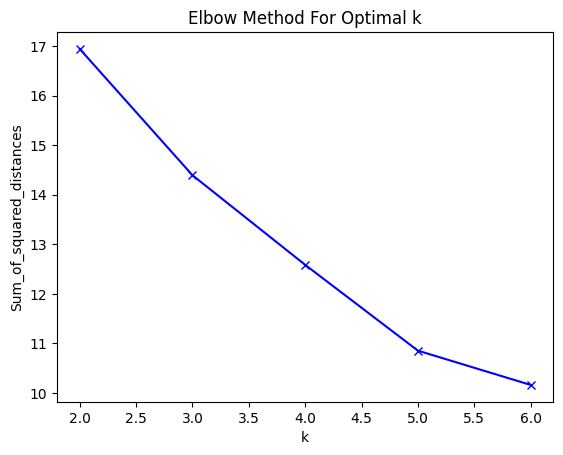

In [104]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for accelerator pedal position using DTW

DBA k-means
DBA silhoutte: 0.79
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[36 37]


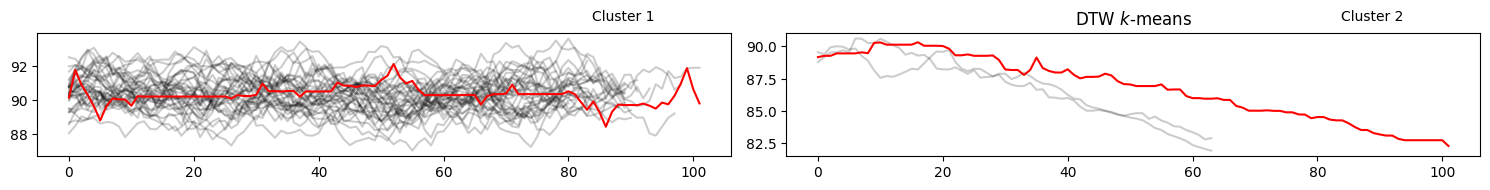

In [105]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=2,
                          n_init=10,
                          max_iter_barycenter=1000,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_pedal)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_pedal, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_pedal[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])

plt.tight_layout()
plt.show()